In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fnm


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier



plt.rcParams['font.family']='Malgun Gothic'



코로나 이후 MZ세대 클러스터링

In [2]:
# fd1=pd.read_excel('d:\\data2\\신한\\finance_data201903.xlsx')
# fd2=pd.read_excel('d:\\data2\\신한\\finance_data201909.xlsx')
fd3=pd.read_excel('d:\\data2\\신한\\finance_data202003.xlsx')
fd4=pd.read_excel('d:\\data2\\신한\\finance_data202009.xlsx')
fd5=pd.read_excel('d:\\data2\\신한\\finance_data202103.xlsx')
df=pd.concat([fd3,fd4,fd5],axis=0)
df.head()

,기준년월,지역구,법정동코드,법정동,집계구코드,나이,성별,직장인여부,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액
0,202003,강남구,11680101,역삼동,1123064010001,2,1,0,0,0,0,1252221,3883375,0,0,0,0,0,0,0
1,202003,강남구,11680101,역삼동,1123064010001,2,2,0,0,0,0,788141,606383,0,0,0,0,0,0,0
2,202003,강남구,11680101,역삼동,1123064010001,3,1,0,0,0,0,1982886,1551318,4956857,0,0,0,0,0,0
3,202003,강남구,11680101,역삼동,1123064010001,3,1,1,3637267,0,0,1706241,7944159,7401428,0,0,0,0,0,0
4,202003,강남구,11680101,역삼동,1123064010001,3,2,0,0,0,0,1556347,3636467,7956413,0,0,0,0,0,0


In [29]:
df1=df.drop(['법정동코드','집계구코드','법정동'],axis=1)

In [30]:
mz=df1.loc[(df1.나이==2)|(df1.나이==3),]

In [31]:
mz1=mz.drop(['기준년월'],axis=1)

In [32]:
mz1

,지역구,나이,성별,직장인여부,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액
0,강남구,2,1,0,0,0,0,1252221,3883375,0,0,0,0,0,0,0
1,강남구,2,2,0,0,0,0,788141,606383,0,0,0,0,0,0,0
2,강남구,3,1,0,0,0,0,1982886,1551318,4956857,0,0,0,0,0,0
3,강남구,3,1,1,3637267,0,0,1706241,7944159,7401428,0,0,0,0,0,0
4,강남구,3,2,0,0,0,0,1556347,3636467,7956413,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211872,중랑구,2,2,0,0,0,0,1224559,2568044,5111428,0,0,0,0,0,0
211873,중랑구,3,1,0,0,0,0,2563707,4085287,6097368,0,0,0,0,0,0
211874,중랑구,3,1,1,2858405,0,0,1433172,7721884,0,0,0,0,0,0,0
211875,중랑구,3,2,0,0,0,0,1653606,2489795,10358065,0,0,0,0,0,0


# 파생변수 생성

총수신 값이 있지만, 총소비가 0인 경우는 입출금통장에 입금하고 해당 월에 지급이 없는 저축용도 통장이거나 입출금 통장 없이 예금, 적금만 하는 고객일 수 있습니다.

총수신은 입출금통장 포함이기 때문에 대부분의 사람이 총수신 값을 가지고 있으며 잔액이 30만원 등과 같이 작은 경우가 많습니다.
그러나 예금, 투자 상품은 상대적으로 큰 금액으로 가입하기 때문에 총수신은 예금, 투자 상품의 평균 값보다 작게 나올 수 있습니다.

In [33]:
print('입출금통장:',mz1.loc[(mz1.총소비금액==0)&(mz1.총수신금액!=0),'총수신금액'].count())
print('예적금통장:',mz1.loc[mz1.총수신금액 < mz1.예적금금액,'총수신금액'].count())
print('신탁투자통장:',mz1.loc[mz1.총수신금액 < mz1.신탁금액,'총수신금액'].count())
print('수익증권추자통장:',mz1.loc[mz1.총수신금액 < mz1.수익증권금액,'총수신금액'].count())

입출금통장: 49148
예적금통장: 87445
신탁투자통장: 361
수익증권추자통장: 255


=> 입출금통장과 예적금 통장은 그 규모가 크기 때문에 유의미한 변수가 될 수 있을 것으로 판단했다. 따라서 예적금용도와 저축용도라는 파생변수를 생성한다.


In [34]:
mz2=mz1.copy()
mz2['저축용도']=np.nan
mz2['예적금용도']=np.nan
mz2['저축용도']=np.where((mz1.총소비금액==0)&(mz1.총수신금액!=0),1,0)
mz2['예적금용도']=np.where(mz1.총수신금액 < mz1.예적금금액,1,0)
mz2.head(15)


,지역구,나이,성별,직장인여부,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
0,강남구,2,1,0,0,0,0,1252221,3883375,0,0,0,0,0,0,0,0,0
1,강남구,2,2,0,0,0,0,788141,606383,0,0,0,0,0,0,0,0,0
2,강남구,3,1,0,0,0,0,1982886,1551318,4956857,0,0,0,0,0,0,0,1
3,강남구,3,1,1,3637267,0,0,1706241,7944159,7401428,0,0,0,0,0,0,0,0
4,강남구,3,2,0,0,0,0,1556347,3636467,7956413,0,0,0,0,0,0,0,1
5,강남구,3,2,1,3662085,0,0,1828120,5200614,4353636,0,0,0,0,0,0,0,0
14,강남구,2,1,0,0,0,0,1456539,5202783,0,0,0,0,0,0,0,0,0
15,강남구,2,2,0,0,0,0,1491023,1958146,0,0,0,0,0,0,0,0,0
16,강남구,3,1,0,0,0,0,1250040,3352383,0,0,0,0,0,0,0,0,0
17,강남구,3,2,0,0,0,0,1473726,3351604,5913888,0,0,0,0,0,0,0,1


20대를 z, 30대 데이터 프레임을 m으로 대입

In [58]:
z=mz2.loc[mz1.나이==2]
m=mz2.loc[mz1.나이==3]

나이 컬럼 드랍한 m1,z1

In [60]:
z1=z.drop(['나이'],axis=1).reset_index(drop=True)
m1=m.drop(['나이'],axis=1).reset_index(drop=True)

In [61]:
pd.options.display.float_format = '{:.5f}'.format

MZ세대의 기술통계량을보면 30대와 20대 간 절대적인 규모의 차이가 존재했다.
따라서 20대와 30대를 구분하는 것은 큰 의미가 없다.
대신 20대와 30대를 따로 나누어서 클러스터링을 하여 특징을 추출한다.

In [62]:
z1.loc[:,'급여입금':].describe()

,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
count,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000,97675.00000
mean,35603.46776,0.00000,26.26366,863948.74114,2372316.80182,2158414.44949,5028.30077,13397.99225,45417.96003,445094.28014,0.00000,338380.80827,0.27198,0.39538
std,290699.29778,0.00000,2914.41631,680504.98686,1921702.98568,2981428.93450,279395.62724,480437.16119,1202139.95628,6413515.99634,0.00000,5838393.74960,0.44498,0.48894
min,0.00000,0.00000,0.00000,0.00000,825.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,1042383.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,900140.00000,1869989.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.00000,0.00000,0.00000,1313862.00000,3142031.00000,3705516.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
max,4433344.00000,0.00000,395793.00000,4757358.00000,20578259.00000,30739631.00000,33275268.00000,57703483.00000,54486571.00000,186000000.00000,0.00000,177822222.00000,1.00000,1.00000


In [121]:
m1.describe()

,성별,직장인여부,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
count,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000,118588.00000
mean,1.50330,0.10511,333350.82839,538.98376,14.21426,1336637.07911,4181886.15981,3938751.99497,90650.42161,36733.80606,1079323.55460,4005135.62136,70458.84436,1460166.01315,0.19042,0.41173
std,0.49999,0.30670,1000124.60233,64819.20197,2046.25538,873455.04511,3382230.90607,4766254.28341,1131083.20845,762504.81701,7308730.15507,20897917.13782,4094654.48594,13320891.96735,0.39264,0.49215
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1592.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,0.00000,0.00000,0.00000,0.00000,799534.50000,1955806.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,2.00000,0.00000,0.00000,0.00000,0.00000,1391055.50000,3244683.00000,2707777.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,2.00000,0.00000,0.00000,0.00000,0.00000,1915662.00000,5238474.25000,6632672.75000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
max,2.00000,1.00000,7194817.00000,11538258.00000,331904.00000,5489070.00000,33379175.00000,44467005.00000,55612646.00000,52744141.00000,108276096.00000,336999920.00000,322639172.00000,232285714.00000,1.00000,1.00000


In [64]:
z1

,지역구,성별,직장인여부,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
0,강남구,1,0,0,0,0,1252221,3883375,0,0,0,0,0,0,0,0,0
1,강남구,2,0,0,0,0,788141,606383,0,0,0,0,0,0,0,0,0
2,강남구,1,0,0,0,0,1456539,5202783,0,0,0,0,0,0,0,0,0
3,강남구,2,0,0,0,0,1491023,1958146,0,0,0,0,0,0,0,0,0
4,강남구,1,0,0,0,0,1964181,3616832,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97670,중랑구,1,0,0,0,0,0,1212992,0,0,0,0,0,0,0,1,0
97671,중랑구,2,0,0,0,0,0,2733757,3834444,0,0,0,0,0,0,1,1
97672,중랑구,2,0,0,0,0,1586835,1224723,0,0,0,0,0,0,0,0,0
97673,중랑구,1,0,0,0,0,766656,2051080,4573152,0,0,0,0,0,0,0,1


In [65]:
z_clustering=z1.loc[:,'급여입금':]
z_clustering

,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
0,0,0,0,1252221,3883375,0,0,0,0,0,0,0,0,0
1,0,0,0,788141,606383,0,0,0,0,0,0,0,0,0
2,0,0,0,1456539,5202783,0,0,0,0,0,0,0,0,0
3,0,0,0,1491023,1958146,0,0,0,0,0,0,0,0,0
4,0,0,0,1964181,3616832,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97670,0,0,0,0,1212992,0,0,0,0,0,0,0,1,0
97671,0,0,0,0,2733757,3834444,0,0,0,0,0,0,1,1
97672,0,0,0,1586835,1224723,0,0,0,0,0,0,0,0,0
97673,0,0,0,766656,2051080,4573152,0,0,0,0,0,0,0,1


In [66]:
sc=StandardScaler()
z_clustering_sc=sc.fit_transform(z_clustering)

In [67]:
z_clustering_sc

array([[-0.12247587,  0.        , -0.00901168, ..., -0.05795816,
        -0.61122456, -0.80866472],
       [-0.12247587,  0.        , -0.00901168, ..., -0.05795816,
        -0.61122456, -0.80866472],
       [-0.12247587,  0.        , -0.00901168, ..., -0.05795816,
        -0.61122456, -0.80866472],
       ...,
       [-0.12247587,  0.        , -0.00901168, ..., -0.05795816,
        -0.61122456, -0.80866472],
       [-0.12247587,  0.        , -0.00901168, ..., -0.05795816,
        -0.61122456,  1.23660643],
       [-0.12247587,  0.        , -0.00901168, ..., -0.05795816,
        -0.61122456,  1.23660643]])

kmeans 클러스터링은 임의의 점을 찍고(첫 중심점) 이를 기반으로 평균 거리가 가까운 변수들끼리 클러스터링한다. 그 이후 중심점을 다시 계산하여 분류를 실시. 이를 계속 반복해서 유사한 성질을 가지고 있는 클러스터를 만들어낸다.

최적의 클러스터링 갯수를 찾기 위한 엘보우 기법 => 오차제곱합의 값이 최소가 되도록 결정하는 방법
kmeans의 inertia_
inertia value는 군집화가 된 후 각 중심점에서 군집의 데이터 간의 거리를 합산한것. 즉 군집의 응집도를 나타낸다. 이 값이 작을 수록 높게 군집화가 되어있다는 것을 의미한다.
따라서 inertia값이 감소하는 정도가 낮아지는 지점이 최적의 k값이 된다
따라서 z세대의 적절한 k값은 4다.

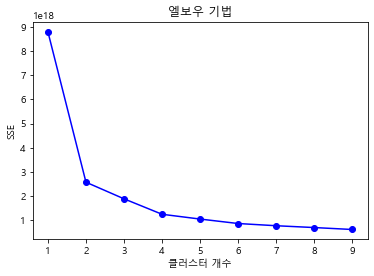

[8.800770600735948e+18, 2.5762833654472197e+18, 1.888881106432725e+18, 1.2490454340231962e+18, 1.0507933481285943e+18, 8.661521468510132e+17, 7.746525717378715e+17, 6.993282624007521e+17, 6.190169928243604e+17]


In [68]:
def elbow(data,length):
    sse=[] #오차제곱합
    for i in range(1,length):
        kmeans=KMeans(n_clusters=i)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.plot(range(1,length),sse,'bo-')
    plt.title('엘보우 기법')
    plt.xlabel('클러스터 개수')
    plt.ylabel('SSE')
    plt.show()
    print(sse)
elbow(z_clustering,10)

In [84]:
# kmeans=KMeans(n_clusters=4,random_state=0)
# clusters=kmeans.fit(z_clustering_sc)
# z_clustering['cluster']=clusters.labels_
# print(z_clustering['cluster'].unique())
# z_clustering
# z_clustering.groupby('cluster').count()

[3 1 0 2]


,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
cluster,,,,,,,,,,,,,,
0,25614,25614,25614,25614,25614,25614,25614,25614,25614,25614,25614,25614,25614,25614
1,36738,36738,36738,36738,36738,36738,36738,36738,36738,36738,36738,36738,36738,36738
2,389,389,389,389,389,389,389,389,389,389,389,389,389,389
3,34934,34934,34934,34934,34934,34934,34934,34934,34934,34934,34934,34934,34934,34934


In [70]:
# kmeans=KMeans(n_clusters=4,random_state=3)
# clusters=kmeans.fit(z_clustering_sc)
# z_clustering['cluster']=clusters.labels_
# # print(z_clustering['cluster'].unique())
# # z_clustering
# z_clustering.groupby('cluster').count()

In [83]:
# kmeans=KMeans(n_clusters=4,random_state=4)
# clusters=kmeans.fit(z_clustering_sc)
# z_clustering['cluster']=clusters.labels_
# # print(z_clustering['cluster'].unique())
# # z_clustering
# z_clustering.groupby('cluster').count()

,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
cluster,,,,,,,,,,,,,,
0,36641,36641,36641,36641,36641,36641,36641,36641,36641,36641,36641,36641,36641,36641
1,389,389,389,389,389,389,389,389,389,389,389,389,389,389
2,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609
3,35036,35036,35036,35036,35036,35036,35036,35036,35036,35036,35036,35036,35036,35036


In [82]:
# kmeans=KMeans(n_clusters=4,random_state=5)
# clusters=kmeans.fit(z_clustering_sc)
# z_clustering['cluster']=clusters.labels_
# # print(z_clustering['cluster'].unique())
# # z_clustering
# z_clustering.groupby('cluster').count()

,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
cluster,,,,,,,,,,,,,,
0,36732,36732,36732,36732,36732,36732,36732,36732,36732,36732,36732,36732,36732,36732
1,389,389,389,389,389,389,389,389,389,389,389,389,389,389
2,25610,25610,25610,25610,25610,25610,25610,25610,25610,25610,25610,25610,25610,25610
3,34944,34944,34944,34944,34944,34944,34944,34944,34944,34944,34944,34944,34944,34944


In [142]:
kmeans=KMeans(n_clusters=4,random_state=100)
clusters=kmeans.fit(z_clustering_sc)
z_clustering['cluster']=clusters.labels_
# print(z_clustering['cluster'].unique())
# z_clustering
z_clustering.groupby('cluster').count()

,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
cluster,,,,,,,,,,,,,,
0,25613,25613,25613,25613,25613,25613,25613,25613,25613,25613,25613,25613,25613,25613
1,34943,34943,34943,34943,34943,34943,34943,34943,34943,34943,34943,34943,34943,34943
2,36730,36730,36730,36730,36730,36730,36730,36730,36730,36730,36730,36730,36730,36730
3,389,389,389,389,389,389,389,389,389,389,389,389,389,389


In [127]:
# kmeans=KMeans(n_clusters=4,random_state=1)
# clusters=kmeans.fit(z_clustering_sc)
# z_clustering['cluster']=clusters.labels_
# # print(z_clustering['cluster'].unique())
# z_clustering
# z_clustering.groupby('cluster').count()

,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
cluster,,,,,,,,,,,,,,
0,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609,25609
1,36640,36640,36640,36640,36640,36640,36640,36640,36640,36640,36640,36640,36640,36640
2,389,389,389,389,389,389,389,389,389,389,389,389,389,389
3,35037,35037,35037,35037,35037,35037,35037,35037,35037,35037,35037,35037,35037,35037


In [143]:
z_clustering.groupby('cluster').mean()

,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
cluster,,,,,,,,,,,,,,
0,0.00000,0.00000,0.00000,0.00000,1751621.22711,562970.28950,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.13556
1,26683.99883,0.00000,8.58541,1186434.16730,2064673.67072,366476.16370,0.00000,201.71577,832.71837,67337.62396,0.00000,720.10131,0.00000,0.00000
2,47122.60378,0.00000,61.67446,1146577.75617,3057604.41587,4945986.75448,8480.81478,34108.65565,4883.40572,189012.35780,0.00000,13474.56983,0.02595,0.95437
3,2093410.03856,0.00000,0.00000,2094661.17995,6169837.67866,4966332.25964,461796.78920,125422.66581,10868210.99229,87864219.32391,0.00000,83627922.87404,0.00000,0.23907


# 0번 클러스터(미취업자)


0번 클러스터는 총 소비금액이 0이기 때문에 주거래은행은 타 은행이고 신한은행에는 소액이 들어있는 계좌 또는 예적금 상품만 이용하고 있는 그룹이다. 

=> 20대 미취업자들이 주거래 은행으로 만들 수 있도록 유도 방안이 필요하다. (휴면계좌를 대상으로 come-back 이벤트, 휴면계좌 주기적으로 입출금 사용시 페이백, 1년이상 입출금 내역 미보유자 우대프로그램, 수익증권 우대 프로그램을 통해 적극적으로 신한은행 계좌를 사용하도록 유도)

=> 주거래 은행이 아니면 소액만 들어있는 통장이 여러개인 케이스 => 휴면 계좌 활성화 방안
=> 예적금 또는 저축용 -> 금융상품을 활용할 수 있도록 유도



# 2번

2번 클러스터는 20대 직장인그룹으로 종류는 적지만 직장인들로 구성된 그룹이기 때문에 전반적으로 그 규모가 다른 그룹보다 크다. 이들은 규모가 더크고 자산운용에 자율성이 더 높은 수익증권(펀드)보다 신탁상품을 더 선호하는 것으로 나타났다. 이들은 수는 적지만 다른 그룹에비해 더 많은 자산을 신한은행을 통해 운영하고 있다. 다만 투자 및 예적금 금액에 비해 담보대출금이 매우 높은데 전세자금대출액이 담보대출금액의 일부인점을 고려한다면, 부동산 상승의 영향으로 인해 대출 부담이 높은 것으로 보인다. 또한 높은 대출금액은 자칫하면 파산으로 이어질 수 있기 떄문에 적절한 대출 관리 수단이 필요하다.



# 1번과 3번

1번 클러스터와 3번클러스터는 급여와 총소비는 큰 차이를 보이지 않았지만 나머지에서는 차이를 보였다. 1번그룹은 적극적으로 은행 상품을 활용하고 있는 반면에 3번클러스터는 이 부분에 있어서 소극적이라고 볼 수 있다. 1번클러스터는 이미 직장생활을 한지 좀 되었고 재태크도 적극적으로 하는 그룹

3번 클러스터의 평균 급여임금이 1번 클러스터보다 0.5배라는 점을 감안하면 3번클러스터는 사회초년생아닐까?
사회 초년생의 금융자산 관리를 도와줄 수 있는 프로그램


In [78]:
X=z_clustering_sc
pca=PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df
pca_df['cluster']=z_clustering['cluster']

C:\Users\wanw9\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\wanw9\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


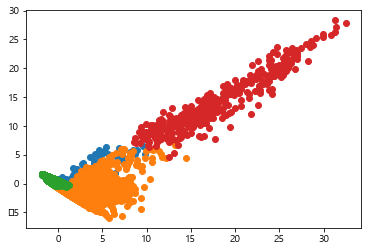

In [85]:
%matplotlib inline

for i in z_clustering['cluster'].unique():
    tmp=pca_df.loc[pca_df['cluster']==i]
    plt.scatter(tmp[0],tmp[1])

In [ ]:
m1=m.drop(['나이'],axis=1).reset_index(drop=True)

In [122]:
m_clustering=m1.loc[:,'급여입금':]
m_clustering

,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
0,0,0,0,1982886,1551318,4956857,0,0,0,0,0,0,0,1
1,3637267,0,0,1706241,7944159,7401428,0,0,0,0,0,0,0,0
2,0,0,0,1556347,3636467,7956413,0,0,0,0,0,0,0,1
3,3662085,0,0,1828120,5200614,4353636,0,0,0,0,0,0,0,0
4,0,0,0,1250040,3352383,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118583,0,0,0,0,7207308,0,0,0,0,0,0,0,1,0
118584,0,0,0,2563707,4085287,6097368,0,0,0,0,0,0,0,1
118585,2858405,0,0,1433172,7721884,0,0,0,0,0,0,0,0,0
118586,0,0,0,1653606,2489795,10358065,0,0,0,0,0,0,0,1


In [123]:
print('입출금통장:',mz1.loc[(mz1.총소비금액==0)&(mz1.총수신금액!=0),'총수신금액'].count())
print('예적금통장:',mz1.loc[mz1.총수신금액 < mz1.예적금금액,'총수신금액'].count())
print('신탁투자통장:',mz1.loc[mz1.총수신금액 < mz1.신탁금액,'총수신금액'].count())
print('수익증권추자통장:',mz1.loc[mz1.총수신금액 < mz1.수익증권금액,'총수신금액'].count())

입출금통장: 49148
예적금통장: 87445
신탁투자통장: 361
수익증권추자통장: 255


In [124]:
m_clustering_sc=sc.fit_transform(m_clustering)

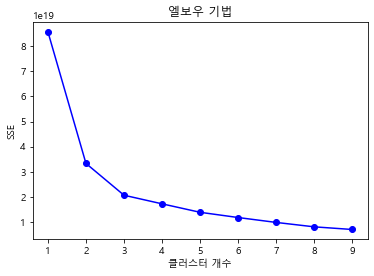

[8.563613662439899e+19, 3.3348802170483053e+19, 2.071387491939623e+19, 1.729580992572471e+19, 1.3931723305434298e+19, 1.185368026231198e+19, 9.906963656064502e+18, 8.155103079059809e+18, 7.100465629066367e+18]


In [125]:
def elbow(data,length):
    sse=[] #오차제곱합
    for i in range(1,length):
        kmeans=KMeans(n_clusters=i)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.plot(range(1,length),sse,'bo-')
    plt.title('엘보우 기법')
    plt.xlabel('클러스터 개수')
    plt.ylabel('SSE')
    plt.show()
    print(sse)
elbow(m_clustering,10)

In [140]:
kmeans=KMeans(n_clusters=5,random_state=10)
clusters=kmeans.fit(m_clustering_sc)
m_clustering['cluster']=clusters.labels_
print(m_clustering['cluster'].unique())
m_clustering
m_clustering.groupby('cluster').count()

[1 3 2 4 0]


,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
cluster,,,,,,,,,,,,,,
0,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240
1,44358,44358,44358,44358,44358,44358,44358,44358,44358,44358,44358,44358,44358,44358
2,39574,39574,39574,39574,39574,39574,39574,39574,39574,39574,39574,39574,39574,39574
3,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518
4,1898,1898,1898,1898,1898,1898,1898,1898,1898,1898,1898,1898,1898,1898


In [134]:
# kmeans=KMeans(n_clusters=5,random_state=3)
# clusters=kmeans.fit(m_clustering_sc)
# m_clustering['cluster']=clusters.labels_
# print(m_clustering['cluster'].unique())
# m_clustering
# m_clustering.groupby('cluster').count()

[0 4 3 2 1]


,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
cluster,,,,,,,,,,,,,,
0,44366,44366,44366,44366,44366,44366,44366,44366,44366,44366,44366,44366,44366,44366
1,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240,22240
2,1891,1891,1891,1891,1891,1891,1891,1891,1891,1891,1891,1891,1891,1891
3,39573,39573,39573,39573,39573,39573,39573,39573,39573,39573,39573,39573,39573,39573
4,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518,10518


In [141]:
m_clustering.groupby('cluster').mean()

,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,저축용도,예적금용도
cluster,,,,,,,,,,,,,,
0,23.05526,0.00000,1.83602,0.00000,2952692.25378,819916.26520,0.53548,0.00000,0.00000,43479.02819,0.00000,0.00000,1.00000,0.10400
1,8148.32249,398.26512,0.00000,1531477.29584,3816827.36909,7503435.82968,39631.16565,18631.42678,123561.18716,2783121.46997,0.00000,41912.16606,0.00762,0.99777
2,20898.21585,635.27521,9.72896,1528348.47339,3179932.24562,568859.20051,8765.47236,557.13360,18167.99305,720335.51920,0.00000,7022.99095,0.00000,0.00000
3,3157703.86071,466.64813,119.77505,2435838.58595,11137086.16876,7646089.69928,270349.86747,29742.30481,7463677.62198,10494946.41871,0.00000,58730.13643,0.00010,0.17874
4,2702685.35195,8536.44679,0.00000,2356604.48683,9464858.13804,6892925.10590,3056720.93467,1683276.18388,22809248.24447,111511034.27028,4402304.23340,89780493.09115,0.00158,0.19705


# 0번클러스터

20대 0번클러스터와 유사하다.  총소비금액이 없고 총수신금액과 예적금 금액만이 존재한다.  담보대출 금액이 다소 있긴한데, 다른 클러스터에 비하면 매우 낮은편, 이 그룹또한 주거래 은행이 별도로 있거나 저축용도로 사용하는 그룹.
20대와 30대 모두 비슷한 비율로 이러한 그룹이 존재하고 있다. 

#  1번과 2번클러스터
1번클러스터와 2번클러스터는 급여입금액에 차이가 컸지만 총 소비금액은 유사한 수준으로 나타났다.  1번 클러스터는 은행상품을 적극적으로 활용하지만 2번클러스터는 적극적으로 활용하지는 않았다.


# 3번과 4번클러스터

4번클러스터는 소수그룹 / 하지만 20대와는 달리 3번클러스터가 규모가 더 컸다. 


3번클러스터는 급여입금액이 크고 총소비금액과 총수신금액은 4번클러스터와 유사하다. 하지만 은행상품은 4번클러스터에 비해 많이 낮은편에 속한다. 그러한 3번클러스터가 예적금금액이 높은것은 급여가 높기 때문으로 추측, 다만 수익증권 금액에 비해 신탁금액 상당히 높은것을 볼 수 있는데 이는 상대적으로 수동적인 수익증권금액(펀드)보다 자산관리사를 통해 능동적으로 자산을 관리할 수 있는 신탁 상품을 많이 선호한다는 것을 알 수 있다. 

4번클러스터는 자영업자 + 고소득자 
4번클러스터와 3번클러스터가 규모의 차이는 존재하지만 비슷한 추세를 보였다. (신탁 선호) => 주택대출금액/ 담보대출금액이 높다.
=> 기혼자? (외부자료를 참고할 필요가 있어보인다)

X1=m_clustering_sc
pca=PCA(n_components=2)
pca.fit(X1)
x_pca = pca.transform(X1)
pca_df2 = pd.DataFrame(x_pca)
pca_df2
pca_df2['cluster']=m_clustering['cluster']

C:\Users\wanw9\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\wanw9\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


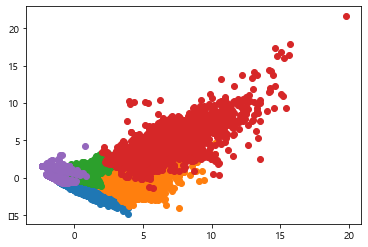

In [146]:
%matplotlib inline

for i in m_clustering['cluster'].unique():
    tmp=pca_df2.loc[pca_df2['cluster']==i]
    plt.scatter(tmp[0],tmp[1])